In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

In [6]:
!pip install spikingjelly

In [1]:
# ============================================================
# 1. Setup & Imports
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Local imports
from src.transforms import get_data_transforms
from src.models import SpikingCNN
from src.evaluate import evaluate_model
from src.datasets import SpectrogramDataset 
from src.train import train
from src.plot_utils import plot_training_curves
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [2]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.9.0+cpu
CUDA available: False


In [3]:
# ============================================================
# 2. Data Preparation
# ============================================================

from torch.utils.data import DataLoader
from src.datasets import SpectrogramDataset, create_dataloaders
from src.transforms import get_data_transforms

# Paths
spectrogram_folder = "spectrograms_new_may"  # folder with our spectrogram PNGs
label_file_path = "label.txt"  #label file
label_map = {'bonafide': 0, 'spoof': 1}
# Get train/test transforms
transformed= get_data_transforms()

# Create datasets
dataset = SpectrogramDataset(
    spectrogram_folder=spectrogram_folder,
    label_file_path=label_file_path,
    label_map=label_map,
    transform=transformed
)


# Create dataloaders with train/val/test split
batch_size = 4
train_loader, val_loader, test_loader = create_dataloaders(dataset, batch_size=batch_size)

# Check out first batch
for data, label in train_loader:
    print(f"Data shape: {data.shape}, Label shape: {label.shape}")
    break
for data, label in test_loader:
    print(f"Data shape: {data.shape}, Label shape: {label.shape}")
    break

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data shape: torch.Size([4, 3, 256, 256]), Label shape: torch.Size([4])
Data shape: torch.Size([4, 3, 256, 256]), Label shape: torch.Size([4])
Train batches: 2230
Validation batches: 279
Test batches: 279


In [5]:
#model initialization
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SpikingCNN()
model = model.to(device)

# Check for multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)


In [6]:
# Training parameters
epochs = 3 #change it to larger epoch like 70 when u get access to GPU
lr = 1e-4

# Call our train function
trained_model, train_losses, val_losses, val_accuracies = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=device
)


Epoch [1/3], Train Loss: 0.6651, Val Loss: 0.6052, Val Accuracy: 0.7040
Epoch [2/3], Train Loss: 0.5857, Val Loss: 0.5874, Val Accuracy: 0.7058
Epoch [3/3], Train Loss: 0.5683, Val Loss: 0.6042, Val Accuracy: 0.7067


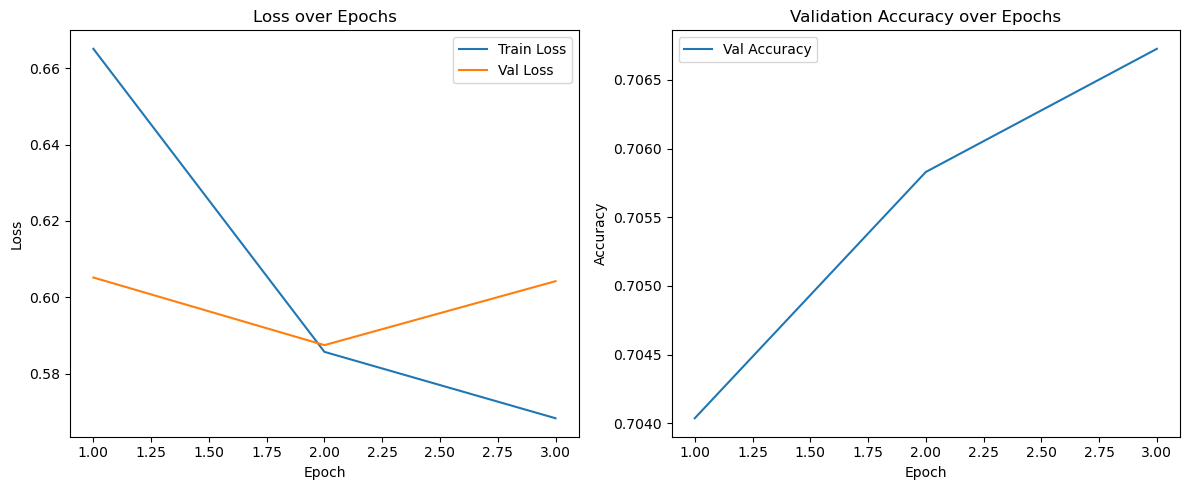

In [7]:
# Plot training curves
plot_training_curves(train_losses, val_losses, val_accuracies)

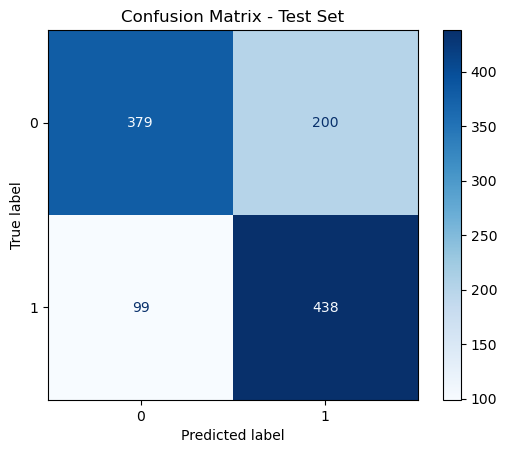


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.65      0.72       579
           1       0.69      0.82      0.75       537

    accuracy                           0.73      1116
   macro avg       0.74      0.74      0.73      1116
weighted avg       0.74      0.73      0.73      1116



In [8]:
# ============================================================
# 5. Evaluation + Confusion Matrix + Classification Report
# ============================================================


device = "cuda" if torch.cuda.is_available() else "cpu"
# After training completes
evaluate_model(trained_model, test_loader, device="cpu")

